In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython import display as ds
import matplotlib.image as mpimg
import cv2
import tensorflow as tf

%matplotlib inline

In [2]:
class Dataset:
    main = 'dataset/UCSD_Anomaly_Dataset.v1p2'
    train_images = np.load('{}/train.npy'.format(main))
    train_images_ = np.load('{}/train_.npy'.format(main))
    test_images = np.load('{}/test.npy'.format(main))
    test_images = np.load('{}/test_.npy'.format(main))

In [3]:
Dataset.train_images.shape

(200, 158, 238, 3)

In [4]:
class Params:
    latent_feature_count = [10,10,3]
    epochs = 10

In [5]:
class Network:
    
    def __init__(self):
        with tf.name_scope('Input'):
            self.x = tf.placeholder(tf.float32, shape=(None, 158, 238, 3), name='X')
            self.x_ = tf.placeholder(tf.float32, shape=(None, 158, 238, 3), name='X_')
        
        self.encoder, self.decoder = self.build_network(self.x)
            
    def build_network(self, x):
        def encoder(x):
            with tf.name_scope('Encoder'):
                x = tf.layers.conv2d(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                print('After 1st Conv', x.get_shape())
                x = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1), )
                print('After 1st Pooling', x.get_shape())

                x = tf.layers.conv2d(x, filters=16, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                print('After 2nd Conv', x.get_shape())
                x = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1))
                print('After 2nd Pooling', x.get_shape())

                x = tf.layers.conv2d(x, filters=8, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                print('After 3rd Conv', x.get_shape())
                encoded = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1))
                print('After 3rd Pooling (Final Encoded)', x.get_shape())
                
                latent = tf.layers.dense(tf.contrib.layers.flatten(encoded), 
                                          units=np.prod(Params.latent_feature_count), 
                                          activation=tf.nn.relu)
                
                print('Latent', latent.get_shape())

                
            return encoded

        def decoder(encoded):
            with tf.name_scope('Decoder'):
                #x = tf.reshape(encoded, [-1] + Params.latent_feature_count)
                x = encoded
                x = tf.layers.conv2d_transpose(x, filters=8, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                print('After 1st conv transpose', x.get_shape())
                x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                print('After 2nd conv transpose', x.get_shape())
                x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                print('After 3rd conv transpose', x.get_shape())
                x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                print('After 4th conv transpose', x.get_shape())
                x = tf.layers.conv2d_transpose(x, filters=3, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                print('After 5th conv transpose', x.get_shape())

                decoded = tf.layers.conv2d_transpose(x, filters=3, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                print('After 6th conv transpose (final decoded)', decoded.get_shape())
                
            return decoded
        
        return encoder, decoder
    
    def get_latent(self):
        with tf.name_scope('Latent'):
            x_ = self.x_
            encoded = self.encoder(x_)
            
        return encoded
    
    def get_decoded(self):
        encoded = self.get_latent()
        x_hat = self.decoder(encoded)
        return x_hat
    
    def get_optimizer_loss(self):
        
        self.x_hat = self.get_decoded()
        
        with tf.name_scope('Optimization'):
            global_step = tf.Variable(0, trainable=False)
            loss = tf.losses.mean_squared_error(labels=self.x, predictions=self.x_hat)
            tf.summary.scalar("loss",loss)
            
            starter_learning_rate = 0.001
            learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               100, 0.6, staircase=True)
            train = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
            tf.summary.scalar("learning_rate",learning_rate)
            
        merged = tf.summary.merge_all()
        return train, merged, loss
        
        

In [6]:
loss_arr = []
with tf.Session() as sess:

    network = Network()
    optim_loss = network.get_optimizer_loss()
    latent = network.get_latent()
    
    train_writer = tf.summary.FileWriter('logdir/cae_train', sess.graph)
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(Params.epochs):
        _, merged, loss = sess.run(optim_loss, feed_dict={network.x:Dataset.train_images,
                                                        network.x_: Dataset.train_images})
        loss_arr.append(loss)
        train_writer.add_summary(merged, epoch)
        if epoch % 1 == 0:
            print('epoch:', epoch, 'loss:', loss)
    
    latent_arr = sess.run(latent,feed_dict={network.x:Dataset.train_images,
                                            network.x_: Dataset.train_images})

After 1st Conv (?, 154, 234, 32)
After 1st Pooling (?, 150, 230, 32)
After 2nd Conv (?, 146, 226, 16)
After 2nd Pooling (?, 142, 222, 16)
After 3rd Conv (?, 138, 218, 8)
After 3rd Pooling (Final Encoded) (?, 138, 218, 8)
Instructions for updating:
Use the retry module or similar alternatives.
Latent (?, 300)
After 1st conv transpose (?, 138, 218, 8)
After 2nd conv transpose (?, 142, 222, 16)
After 3rd conv transpose (?, 146, 226, 32)
After 4th conv transpose (?, 150, 230, 32)
After 5th conv transpose (?, 154, 234, 3)
After 6th conv transpose (final decoded) (?, 158, 238, 3)
After 1st Conv (?, 154, 234, 32)
After 1st Pooling (?, 150, 230, 32)
After 2nd Conv (?, 146, 226, 16)
After 2nd Pooling (?, 142, 222, 16)
After 3rd Conv (?, 138, 218, 8)
After 3rd Pooling (Final Encoded) (?, 138, 218, 8)
Latent (?, 300)
epoch: 0 loss: 11037.914
epoch: 5 loss: 11536.181
epoch: 10 loss: 11536.181
epoch: 15 loss: 11536.181
epoch: 20 loss: 11536.181
epoch: 25 loss: 11536.181
epoch: 30 loss: 11536.181
ep

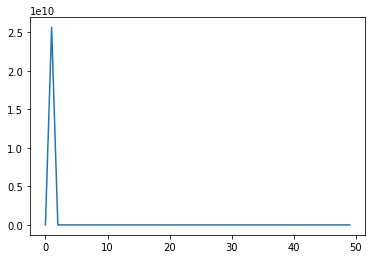

In [7]:
plt.plot(loss_arr)

In [8]:
np.save('{}/latent_train.npy'.format(Dataset.main),latent_arr)